<a href="https://colab.research.google.com/github/pkonowrocki/Multiple-pixels-attack/blob/master/MultiplePixelsAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#install required files
!pip3 install torch torchvision
!pip3 install matplotlib

file_id = '1Iz4CTYuTT-_eS1HrIU410VkeomP5dl0R'

#authentication
from google.colab import auth
auth.authenticate_user()

#build Gdrive service
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

try:
  import io
  from googleapiclient.http import MediaIoBaseDownload

  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    _, done = downloader.next_chunk()
  downloaded.seek(0)
  print('Downloaded file')
  import pickle
  dataset = pickle.load(downloaded)
  assert type(dataset)!="<class 'dict'>", "Something went wrong with downloading file"
  print("Dataset ready")
  
  from urllib.request import urlopen
  idx2label = pickle.load(urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )
  print("Labels ready")

except:
  print("Something wrong with file")
  print("Trying to download the file and upload it to a Gdrive")
  #downloading dataset
  !curl http://ml.cs.tsinghua.edu.cn/~chenxi/dataset/val224_compressed.pkl --output val224_compressed.pkl
    
  #mounting Gdrive 
  from google.colab import drive
  drive.mount('/content/gdrive')
  #upload dataset to Gdrive
  from googleapiclient.http import MediaFileUpload
  file_metadata = {
    'name': 'val224_compressed'
  }
  media = MediaFileUpload('val224_compressed.pkl',
                        resumable=True)
  created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
  print('File ID: {}'.format(created.get('id')))

Downloaded file
Dataset ready
Labels ready


In [90]:
import numpy as np

PIXELS_COUNT = 5


class Individual:

    def __init__(self, code):
        self.code = code

    @staticmethod
    def from_params(x, y, distortion):
        code = np.zeros((PIXELS_COUNT, 5), dtype=float)
        code[:, 0] = x
        code[:, 1] = y
        code[:, 2:5] = distortion
        return Individual(code)

    def get_mutant(self, population, f_param):
        r1, r2, r3 = [ind.code for ind in np.random.choice(population, 3, replace=False)]
        mutant_code = r1 + f_param * (r2 + r3)
        return Individual(mutant_code)

    def crossover_with(self, mutant, c_r, c_p, c_rgb):
        crossover_result = np.zeros((PIXELS_COUNT, 5), dtype=float)
        if np.random.rand() < c_p:
            crossover_result[:, 0:2] = self._crossover(
                self.code[:, 0:2], mutant.code[:, 0:2], c_r)
        if np.random.rand() < c_rgb:
            crossover_result[:, 2:5] = self._crossover(
                self.code[:, 2:5], mutant.code[:, 2:5], c_r)
        return Individual(crossover_result)

    def _crossover(self, first, second, c_r):
        return self._binomial_crossover(
            first,
            self._expotential_crossover(first, second),
            c_r
        )

    def _expotential_crossover(self, first, second):
        result = second
        start = np.random.randint(0, PIXELS_COUNT)
        end = np.random.randint(start, PIXELS_COUNT)
        result[start: end + 1, :] = first[start: end + 1, :]
        return result

    def _binomial_crossover(self, first, second, c_r):
        result = second
        for i in range(PIXELS_COUNT):
            if np.random.rand() < c_r:
                result[i, :] = first[i, :]
        return result
    
    def show_image(self, num_from_dataset):
        import matplotlib.pyplot as plt
        im = np.array(_str2img(dataset["data"][num_from_dataset]), dtype='int32')
        for i in range(self.code.shape[0]):
            im[int(self.code[(i,0)]), int(self.code[(i,1)])] += np.int32(self.code[i,2:5])  
        plt.title(idx2label[dataset["target"][num_from_dataset]])
        plt.imshow(im)
        plt.show()
        
print("Individual loaded")

Individual loaded


In [0]:
import numpy as np
from itertools import product
#from individual import Individual

PIXELS_COUNT = 5


class Population:
    """
    Class representing population of individuals

    """

    def __init__(self, iteration, cardinality, image_size, c_p, c_rgb, c_r, f_param, individuals=None):
        self.iteration = iteration
        self.cardinality = cardinality
        self.image_size = image_size
        self.c_p = c_p
        self.c_rgb = c_rgb
        self.c_r = c_r
        self.f_param = f_param

        if individuals == None:
            self.individuals = self._initialize_individuals(
                cardinality, image_size)
        else:
            self.individuals = individuals

    def _initialize_individuals(self, cardinality, image_size):
        individuals = []
        height, width = image_size
        possible_positions = np.array(
            list(product(range(height), range(width))))
        positions = possible_positions[np.random.randint(0,
                                                         height * width, cardinality * PIXELS_COUNT)]

        for i in range(cardinality):
            code = np.zeros((PIXELS_COUNT, 5))
            code[:, 2:5] = np.random.normal(128, 127, (PIXELS_COUNT, 3)) / 256
            code[:, 0:2] = positions[i * PIXELS_COUNT: i *
                                     PIXELS_COUNT + PIXELS_COUNT]
            individuals.append(Individual(code))
            i += 1

        return individuals

    def generate_next(self, objective_function):
        new_individuals = []
        for i in range(self.cardinality):
            mutant = self.individuals[i].get_mutant(
                self.individuals, self.f_param)
            descendant = self.individuals[i].crossover_with(
                mutant, self.c_r, self.c_p, self.c_rgb)
            if objective_function(descendant) >= objective_function(self.individuals[i]):
                new_individuals.append(descendant)
            else:
                new_individuals.append(self.individuals[i])
            i += 1
        return Population(self.iteration + 1, self.cardinality, self.image_size, self.c_p, self.c_r, self.c_rgb, self.f_param, new_individuals)

In [11]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)

import torchvision.models as models
net = models.shufflenet_v2_x1_0(pretrained=True).to(device)
net.eval()

print("Network ready")

cuda:0
Network ready


In [92]:
import torch.nn as nn
import numpy as np
import cv2
import torch


#softmax layer to normalize output
m = nn.Softmax()

#mean and std of input normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#convert str to image
def _str2img(str_b):
    return cv2.imdecode(np.frombuffer(str_b, np.uint8), cv2.IMREAD_COLOR)


def fitness_function(individual, num_from_dataset):
    im = np.array(_str2img(dataset["data"][num_from_dataset]), dtype='float64')
    for i in range(individual.code.shape[0]):
        im[int(individual.code[(i,0)]), int(individual.code[(i,1)])] += individual.code[i,2:5]          
    im = torch.from_numpy(im).view(1, 3, 224, 224).to(device=device, dtype=torch.float)
    im.div_(255.)
    im[:, 0, :, :].sub_(mean[0]).div_(std[0])
    im[:, 1, :, :].sub_(mean[1]).div_(std[1])
    im[:, 2, :, :].sub_(mean[2]).div_(std[2])
    output = net(im)
    output = m(output)
    return output.cpu().detach().numpy()[0, dataset["target"][num_from_dataset]]
print("Fitness function loaded")

Fitness function loaded


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.2649025
0.31756043


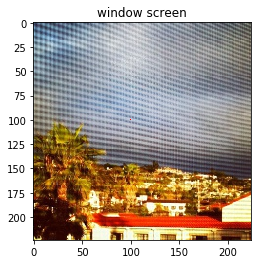

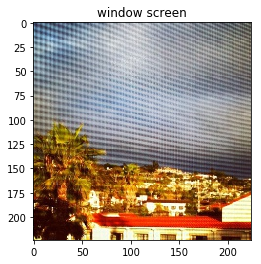

In [93]:
#test individual
first_of_its_kind = Individual.from_params(100,100,[90,-90,-80])
how_fit = fitness_function(first_of_its_kind, 125)
print(how_fit)

second_of_its_kind = Individual.from_params(100,100,[0,0,0])
how_fit = fitness_function(second_of_its_kind, 125)
print(how_fit)

first_of_its_kind.show_image(125)
second_of_its_kind.show_image(125)
#we can pretty much do it by hand XD

In [9]:
#find positive examples
import numpy as np
import cv2
import torch
import torch.nn as nn

def str2img(str_b):
    return cv2.imdecode(np.fromstring(str_b, np.uint8), cv2.IMREAD_COLOR)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

print("Got "+str(len(dataset["target"])) +" samples")
m = nn.Softmax()
positive = []

for i in range(len(dataset["target"])):
  image = str2img(dataset["data"][i])
  image = torch.from_numpy(image).view(1, 3, 224, 224).to(device=device, dtype=torch.float)
  image.div_(255.)
  image[:, 0, :, :].sub_(mean[0]).div_(std[0])
  image[:, 1, :, :].sub_(mean[1]).div_(std[1])
  image[:, 2, :, :].sub_(mean[2]).div_(std[2])
  target = dataset["target"][i]
  output = net(image)
  output = m(output)
  values, indices = torch.max(output, 1)
  if(target==indices.item()):
    print("Image #"+str(i)+"\tprobability: "+str(values.item()*100))
    positive.append((i, values.item()*100))

print(positive)

Got 50000 samples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Image #125	probability: 31.756043434143066
Image #3671	probability: 52.99723744392395
Image #3852	probability: 22.833256423473358
Image #3945	probability: 38.58278691768646
Image #4407	probability: 50.152260065078735
Image #4804	probability: 56.79970383644104
Image #5092	probability: 53.26223969459534
Image #5714	probability: 18.535876274108887
Image #5996	probability: 38.04589509963989
Image #6186	probability: 73.44810962677002
Image #6226	probability: 21.50140255689621
Image #6729	probability: 74.37291145324707
Image #7722	probability: 45.38203477859497
Image #8411	probability: 95.47148942947388
Image #8581	probability: 56.022441387176514
Image #8669	probability: 21.05119526386261
Image #9049	probability: 9.854044765233994
Image #9379	probability: 44.21263933181763
Image #9526	probability: 93.24731826782227
Image #9614	probability: 17.411281168460846
Image #9673	probability: 14.063216745853424
Image #9705	probability: 75.42051076889038
Image #9820	probability: 40.275898575782776
Imag

KeyboardInterrupt: ignored

web site, website, internet site, site


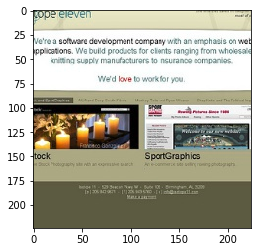

In [94]:
import numpy as np
import cv2
import torch
import torch.nn

def str2img(str_b):
    return cv2.imdecode(np.frombuffer(str_b, np.uint8), cv2.IMREAD_COLOR)

positive = [(125, 70.38662433624268), (230, 29.68287467956543), (1121, 34.66236591339111), (1204, 80.14419674873352), (1293, 99.26235675811768), (1734, 22.51041829586029), (4460, 30.719149112701416), (4914, 22.840631008148193), (5251, 31.67714774608612), (5763, 10.272357612848282), (6234, 20.63409835100174), (6729, 77.3688018321991), (6906, 24.49241131544113), (7640, 20.38220465183258), (8581, 88.46515417098999), (9537, 35.77677011489868), (9614, 59.678393602371216), (10247, 50.593119859695435), (11610, 35.52859425544739), (11749, 75.22026896476746), (12299, 57.825249433517456), (12488, 98.24746251106262), (13385, 26.576286554336548), (13627, 41.33410155773163), (13661, 21.732445061206818), (13734, 39.57911729812622), (14359, 14.517764747142792), (15384, 83.67582559585571), (15639, 11.083117872476578), (18307, 8.994264155626297), (19241, 68.18674802780151), (19474, 89.1351580619812), (19753, 72.94465899467468), (20060, 69.57603096961975), (20698, 78.03838849067688), (21335, 56.468266248703), (21461, 77.93958783149719), (22785, 65.87823033332825), (23355, 35.305508971214294), (25701, 29.582718014717102), (26628, 43.83417367935181), (26703, 8.497815579175949), (26822, 37.64067590236664), (27731, 29.25107181072235), (29598, 98.43541383743286), (29876, 66.34024977684021), (31332, 34.71480906009674), (31924, 33.64042639732361), (31969, 76.82187557220459), (32663, 48.51921200752258), (33350, 98.14919829368591), (35491, 67.31398105621338), (39049, 64.29259181022644), (39705, 86.5737795829773), (40235, 35.74826121330261), (40244, 48.99843633174896), (42084, 53.020232915878296), (42275, 13.818688690662384), (42591, 52.02655792236328), (42972, 44.17412579059601), (43095, 71.31219506263733), (44495, 6.340372562408447), (45326, 23.5866978764534), (46550, 72.07267880439758), (47259, 26.392918825149536), (48606, 85.98803877830505), (48816, 49.71528351306915), (48953, 52.26907134056091), (49117, 18.790780007839203), (49648, 34.377798438072205), (49709, 56.61540627479553)]

import matplotlib.pyplot as plt
i = 47259
plt.imshow(str2img(dataset["data"][i]))
print(idx2label[dataset["target"][i]])

Sources: [Dataset](https://github.com/aaron-xichen/pytorch-playground) [Neural network model](https://pytorch.org/docs/stable/torchvision/models.html)